# Analysis of DWEL spectral point cloud for noise removal

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [37]:
ptsfile = "/projectnb/echidna/lidar/DWEL_Processing/HF2014/Hardwood20140503/spectral-points-by-union/HFHD20140503-dual-points/HFHD_20140503_C_dual_cube_bsfix_pxc_update_atp2_ptcl_points.txt"

In [85]:
# test python file object
with open(ptsfile, 'r') as pts:
    pts.readline()
    pts.readline()
    for i, line in enumerate(pts):
        print "{0:d} = {1:s}".format(i, line)
        if i>10:
            break

0 = x,y,z,d_I_nir,d_I_swir,return_number,number_of_returns,shot_number,range,theta,phi,sample,line,fwhm_nir,fwhm_swir,qa,r,g,b

1 = 0.000,0.000,18.247,56.032,125.823,1,2,2,16.877,0.000,18.500,1,2,0.502,0.522,0,51,11,0

2 = 0.000,0.000,19.869,76.233,69.814,2,2,2,18.499,0.000,18.500,1,2,0.560,0.434,0,26,17,0

3 = 0.000,0.000,19.778,75.044,45.489,1,2,3,18.408,0.000,18.620,1,3,0.588,0.492,0,16,17,0

4 = 0.000,0.000,22.149,96.454,47.848,2,2,3,20.779,0.000,18.620,1,3,0.598,0.590,0,17,23,0

5 = 0.000,0.000,18.227,50.930,76.395,1,2,4,16.857,0.000,18.730,1,4,0.000,0.650,2,29,10,0

6 = 0.000,0.000,19.865,47.317,65.070,2,2,4,18.495,0.000,18.730,1,4,0.973,0.667,0,24,9,0

7 = 0.000,0.000,18.243,224.961,201.447,1,1,6,16.873,0.000,18.960,1,6,0.596,0.619,0,85,60,0

8 = 0.000,0.000,18.396,100.503,45.724,1,2,7,17.026,0.000,19.080,1,7,0.000,1.001,2,16,24,0

9 = 0.000,0.000,19.889,111.225,54.818,2,2,7,18.520,0.000,19.080,1,7,0.902,0.972,0,20,27,0

10 = 0.000,0.000,18.446,149.984,91.790,1,2,8,17.076,0.000,

In [59]:
cind = {'x':0, 'y':1, 'z':2, \
       'd_i_nir':3, 'd_i_swir':4, \
        'number_of_returns':6, 'range':8, \
       'fwhm_nir':13, 'fwhm_swir':14, \
       'qa':15}
data = np.genfromtxt(ptsfile, skiprows=3, delimiter=',', comments=None, \
                     usecols=(cind['x'], cind['y'], cind['z'], cind['d_i_nir'], cind['d_i_swir'], \
                              cind['number_of_returns'], cind['range'], \
                              cind['fwhm_nir'], cind['fwhm_swir'], cind['qa']))

In [61]:
dind = {'x':0, 'y':1, 'z':2, \
       'd_i_nir':3, 'd_i_swir':4, \
        'number_of_returns':5, 'range':6, \
       'fwhm_nir':7, 'fwhm_swir':8, \
       'qa':9}
# remove zero-hit points
tmpind = np.where(data[:, dind['number_of_returns']]>1e-10)[0]
data = data[tmpind, :]

In [53]:
zero_nir_fwhm_ind = np.where(np.fabs(data[:, dind['fwhm_nir']])<1e-10)[0]
zero_swir_fwhm_ind = np.where(np.fabs(data[:, dind['fwhm_swir']])<1e-10)[0]
zero_both_fwhm_ind = np.where(np.logical_and(data[:, dind['fwhm_nir']]<1e-10, data[:, dind['fwhm_swir']]<1e-10))[0]
# zero_fwhm_ind = np.where(np.fabs(data[:, dind['fwhm_nir']])<1e-10)[0]
print 'number of points with zero or negative nir fwhm = {0:d}'.format(len(zero_nir_fwhm_ind))
print 'number of points with zero or negative swir fwhm = {0:d}'.format(len(zero_swir_fwhm_ind))
print 'number of points with zero or negative both fwhm = {0:d}'.format(len(zero_both_fwhm_ind))

number of points with zero or negative nir fwhm = 1001628
number of points with zero or negative swir fwhm = 375756
number of points with zero or negative both fwhm = 1419


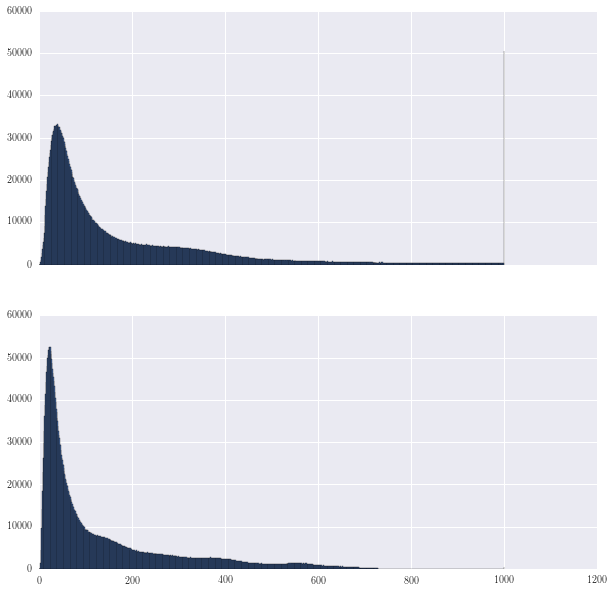

In [52]:
# plot histogram of fwhm
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 10))
nir_hist = ax1.hist(data[:, dind['d_i_nir']], bins=1000)
swir_hist = ax2.hist(data[:, dind['d_i_swir']], bins=1000)

In [74]:
nir_cal_par = np.array([41814.061908*0.984807753*17.376,0.000071,0.383203,104574.246266,1.624433])
swir_cal_par = np.array([88357.438795*0.984807753*7.3,0.000071,0.445864,104574.246266,1.670920])

In [54]:
def calcNEAR(rgs, noise_dn, cal_par):
    """
    Calculate Noise Equivalent Apparent Reflectance at given ranges, noise level and calibration parameters.
    
    Args:
    
        cal_par (1D numpy array)
    """
    kr = 1.0 + cal_par[1]*np.exp(-1*cal_par[2]*rgs)
    kr = kr**(-1*cal_par[3])
    NEAR = noise_dn * rgs**cal_par[4]/(cal_par[0]*kr)
    
    return NEAR

In [75]:
rgs = np.arange(0.5, 100, 0.075)
nir_near = calcNEAR(rgs, 110, nir_cal_par)
swir_near = calcNEAR(rgs, 37, swir_cal_par)

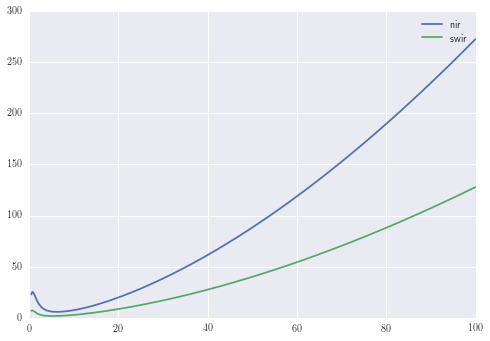

In [76]:
fig, ax = plt.subplots()
ax.plot(rgs, nir_near*1000, label='nir')
ax.plot(rgs, swir_near*1000, label='swir')
plt.legend()

In [79]:
i_scale = 1e3
# filter point cloud with NEAR
nir_noise_dn = 110.084/2.0*3
nir_near = calcNEAR(data[:, dind['range']], nir_noise_dn, nir_cal_par)
swir_noise_dn = 37.28/2.0*3
swir_near = calcNEAR(data[:, dind['range']], swir_noise_dn, swir_cal_par)

In [73]:
nir_signal_pts_file = ptsfile[:-4]+'_nir_signal.txt'
nir_noise_pts_file = ptsfile[:-4]+'_nir_noise.txt'
headerstr = 'x,y,z,d_I_nir,d_I_swir,range,qa'
fmtstr = "%.3f "*6 + "%d "
fmtstr = fmtstr.strip().split(' ')

select_ind = np.where(data[:, dind['d_i_nir']] > nir_near*i_scale)[0]
outdata = np.hstack((data[select_ind, dind['x']:dind['x']+1],\
                     data[select_ind, dind['y']:dind['y']+1],\
                     data[select_ind, dind['z']:dind['z']+1],\
                     data[select_ind, dind['d_i_nir']:dind['d_i_nir']+1],\
                     data[select_ind, dind['d_i_swir']:dind['d_i_swir']+1],\
                     data[select_ind, dind['range']:dind['range']+1],\
                     data[select_ind, dind['qa']:dind['qa']+1]\
                    ))
np.savetxt(nir_signal_pts_file, outdata, delimiter=',', fmt=fmtstr, header=headerstr.rstrip(), comments='')

select_ind = np.where(data[:, dind['d_i_nir']] <= nir_near*i_scale)[0]
outdata = np.hstack((data[select_ind, dind['x']:dind['x']+1],\
                     data[select_ind, dind['y']:dind['y']+1],\
                     data[select_ind, dind['z']:dind['z']+1],\
                     data[select_ind, dind['d_i_nir']:dind['d_i_nir']+1],\
                     data[select_ind, dind['d_i_swir']:dind['d_i_swir']+1],\
                     data[select_ind, dind['range']:dind['range']+1],\
                     data[select_ind, dind['qa']:dind['qa']+1]\
                    ))
np.savetxt(nir_noise_pts_file, outdata, delimiter=',', fmt=fmtstr, header=headerstr.rstrip(), comments='')

In [80]:
signal_pts_file = ptsfile[:-4]+'_signal.txt'
noise_pts_file = ptsfile[:-4]+'_noise.txt'
headerstr = 'x,y,z,d_I_nir,d_I_swir,range,qa'
fmtstr = "%.3f "*6 + "%d "
fmtstr = fmtstr.strip().split(' ')

select_ind = np.where(np.logical_and(data[:, dind['d_i_nir']] > nir_near*i_scale, \
                                     data[:, dind['d_i_swir']] > swir_near*i_scale))[0]
outdata = np.hstack((data[select_ind, dind['x']:dind['x']+1],\
                     data[select_ind, dind['y']:dind['y']+1],\
                     data[select_ind, dind['z']:dind['z']+1],\
                     data[select_ind, dind['d_i_nir']:dind['d_i_nir']+1],\
                     data[select_ind, dind['d_i_swir']:dind['d_i_swir']+1],\
                     data[select_ind, dind['range']:dind['range']+1],\
                     data[select_ind, dind['qa']:dind['qa']+1]\
                    ))
np.savetxt(signal_pts_file, outdata, delimiter=',', fmt=fmtstr, header=headerstr.rstrip(), comments='')

select_ind = np.where(np.logical_or(data[:, dind['d_i_nir']] <= nir_near*i_scale, \
                                    data[:, dind['d_i_swir']] <= swir_near*i_scale))[0]
outdata = np.hstack((data[select_ind, dind['x']:dind['x']+1],\
                     data[select_ind, dind['y']:dind['y']+1],\
                     data[select_ind, dind['z']:dind['z']+1],\
                     data[select_ind, dind['d_i_nir']:dind['d_i_nir']+1],\
                     data[select_ind, dind['d_i_swir']:dind['d_i_swir']+1],\
                     data[select_ind, dind['range']:dind['range']+1],\
                     data[select_ind, dind['qa']:dind['qa']+1]\
                    ))
np.savetxt(noise_pts_file, outdata, delimiter=',', fmt=fmtstr, header=headerstr.rstrip(), comments='')

In [81]:
signal_pts_file = ptsfile[:-4]+'_signal.txt'
noise_pts_file = ptsfile[:-4]+'_noise.txt'
headerstr = 'x,y,z,d_I_nir,d_I_swir,range,qa'
fmtstr = "%.3f "*6 + "%d "
fmtstr = fmtstr.strip().split(' ')

select_ind = np.where(np.logical_or(data[:, dind['d_i_nir']] > 75, \
                                     data[:, dind['d_i_swir']] > 75))[0]
outdata = np.hstack((data[select_ind, dind['x']:dind['x']+1],\
                     data[select_ind, dind['y']:dind['y']+1],\
                     data[select_ind, dind['z']:dind['z']+1],\
                     data[select_ind, dind['d_i_nir']:dind['d_i_nir']+1],\
                     data[select_ind, dind['d_i_swir']:dind['d_i_swir']+1],\
                     data[select_ind, dind['range']:dind['range']+1],\
                     data[select_ind, dind['qa']:dind['qa']+1]\
                    ))
np.savetxt(signal_pts_file, outdata, delimiter=',', fmt=fmtstr, header=headerstr.rstrip(), comments='')

select_ind = np.where(np.logical_and(data[:, dind['d_i_nir']] <= 75, \
                                    data[:, dind['d_i_swir']] <= 75))[0]
outdata = np.hstack((data[select_ind, dind['x']:dind['x']+1],\
                     data[select_ind, dind['y']:dind['y']+1],\
                     data[select_ind, dind['z']:dind['z']+1],\
                     data[select_ind, dind['d_i_nir']:dind['d_i_nir']+1],\
                     data[select_ind, dind['d_i_swir']:dind['d_i_swir']+1],\
                     data[select_ind, dind['range']:dind['range']+1],\
                     data[select_ind, dind['qa']:dind['qa']+1]\
                    ))
np.savetxt(noise_pts_file, outdata, delimiter=',', fmt=fmtstr, header=headerstr.rstrip(), comments='')